In [1]:
source("/secure/projects/HTAPP_MBC/src/init_phase2.R")

Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3
Loading combined annotation: annot


In [2]:
library(runner)

In [3]:
infercnvDir=paste0(analysisDir,"/00_infercnv/")

In [4]:
out=paste0(infercnvDir,"/summarized/")
dir.create(out,showWarnings = FALSE)

In [5]:
samples=list.dirs(infercnvDir,recursive = FALSE,full.names = FALSE)
samples=samples[samples%in%sample_sheet$sampleid]
samples

[1] "HTAPP-211-SMP-6751" "HTAPP-213-SMP-6752" "HTAPP-223-SMP-6755"
 [4] "HTAPP-223-SMP-7537" "HTAPP-225-SMP-6756" "HTAPP-226-SMP-6757"
 [7] "HTAPP-231-SMP-6758" "HTAPP-232-SMP-6759" "HTAPP-254-SMP-571" 
[10] "HTAPP-262-SMP-602"  "HTAPP-262-SMP-610"  "HTAPP-285-SMP-751" 
[13] "HTAPP-309-SMP-871"  "HTAPP-313-SMP-932"  "HTAPP-321-SMP-1021"
[16] "HTAPP-330-SMP-1082" "HTAPP-364-SMP-1321" "HTAPP-382-SMP-1441"
[19] "HTAPP-394-SMP-1561" "HTAPP-414-SMP-1681" "HTAPP-423-SMP-1741"
[22] "HTAPP-425-SMP-1771" "HTAPP-514-SMP-6760" "HTAPP-516-SMP-6761"
[25] "HTAPP-519-SMP-6762" "HTAPP-521-SMP-6763" "HTAPP-525-SMP-6765"
[28] "HTAPP-562-SMP-2581" "HTAPP-586-SMP-8599" "HTAPP-589-SMP-2851"
[31] "HTAPP-589-SMP-2860" "HTAPP-600-SMP-2941" "HTAPP-611-SMP-3062"
[34] "HTAPP-627-SMP-3242" "HTAPP-649-SMP-3422" "HTAPP-662-SMP-3602"
[37] "HTAPP-735-SMP-3841" "HTAPP-745-SMP-3961" "HTAPP-749-SMP-3991"
[40] "HTAPP-752-SMP-4051" "HTAPP-759-SMP-8359" "HTAPP-783-SMP-4081"
[43] "HTAPP-806-SMP-6789" "HTAPP-806-SMP-6800" "HTAPP-812-SMP-8239"
[46] "HTAPP-814-SMP-6879" "HTAPP-835-SMP-6999" "HTAPP-851-SMP-4351"
[49] "HTAPP-853-SMP-4381" "HTAPP-861-SMP-7028" "HTAPP-862-SMP-7059"
[52] "HTAPP-862-SMP-7060" "HTAPP-870-SMP-7089" "HTAPP-873-SMP-7119"
[55] "HTAPP-878-SMP-7149" "HTAPP-880-SMP-7179" "HTAPP-887-SMP-7239"
[58] "HTAPP-887-SMP-7250" "HTAPP-889-SMP-7269" "HTAPP-889-SMP-7270"
[61] "HTAPP-890-SMP-7299" "HTAPP-895-SMP-7359" "HTAPP-908-SMP-4412"
[64] "HTAPP-917-SMP-4531" "HTAPP-944-SMP-7479" "HTAPP-947-SMP-7509"
[67] "HTAPP-963-SMP-4741" "HTAPP-982-SMP-7629" "HTAPP-983-SMP-7659"
[70] "HTAPP-988-SMP-7749" "HTAPP-997-SMP-7789"

### Without taking into account clusters

In [ ]:
#calculate scores
for (sample in head(samples,-1)){
    message(sample)
    obj=readRDS(paste0(infercnvDir,sample,"/out/run.final.infercnv_obj"))
    cnv_score=as.data.table(apply(obj@expr.data,2,function(x){mean(abs(log(runner(x,k=50,f=function(x){x[which.min(abs(1-x))]}))))}),keep.rownames = "cellid")
    cnv_score[,sampleID:=sample,]
    write.table(cnv_score,paste0(out,"/cnv_scores_",sample,".tsv"),sep="\t",row.names = FALSE,quote = FALSE)   
}


In [ ]:
# calculate correlations
for (sample in head(samples,-1)){
    message(sample)
    cnv_score=fread(paste0(out,"/cnv_scores_",sample,".tsv"))  
    obj=readRDS(paste0(infercnvDir,sample,"/out/run.final.infercnv_obj"))
    
    max_mal=tail( order(cnv_score$V2), 80 )
    mal_profile=apply(obj@expr.data[,max_mal],1,mean)
    cors=as.data.table(apply(obj@expr.data,2,function(x){ if (sd(x)==0){ NA} else cor(x,mal_profile)}),keep.rownames = "cellid")
    cors[,sampleID:=sample,]
    
    write.table(cors,paste0(out,"/cnv_cors_",sample,".tsv"),sep="\t",row.names = FALSE,quote = FALSE)   
}


In [133]:
all_scores=data.table()
for (sample in head(samples,-1)){
    cnv_scores=fread(paste0(out,"/cnv_scores_",sample,".tsv"))   
    all_scores=rbindlist(list(all_scores,cnv_scores))
}

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


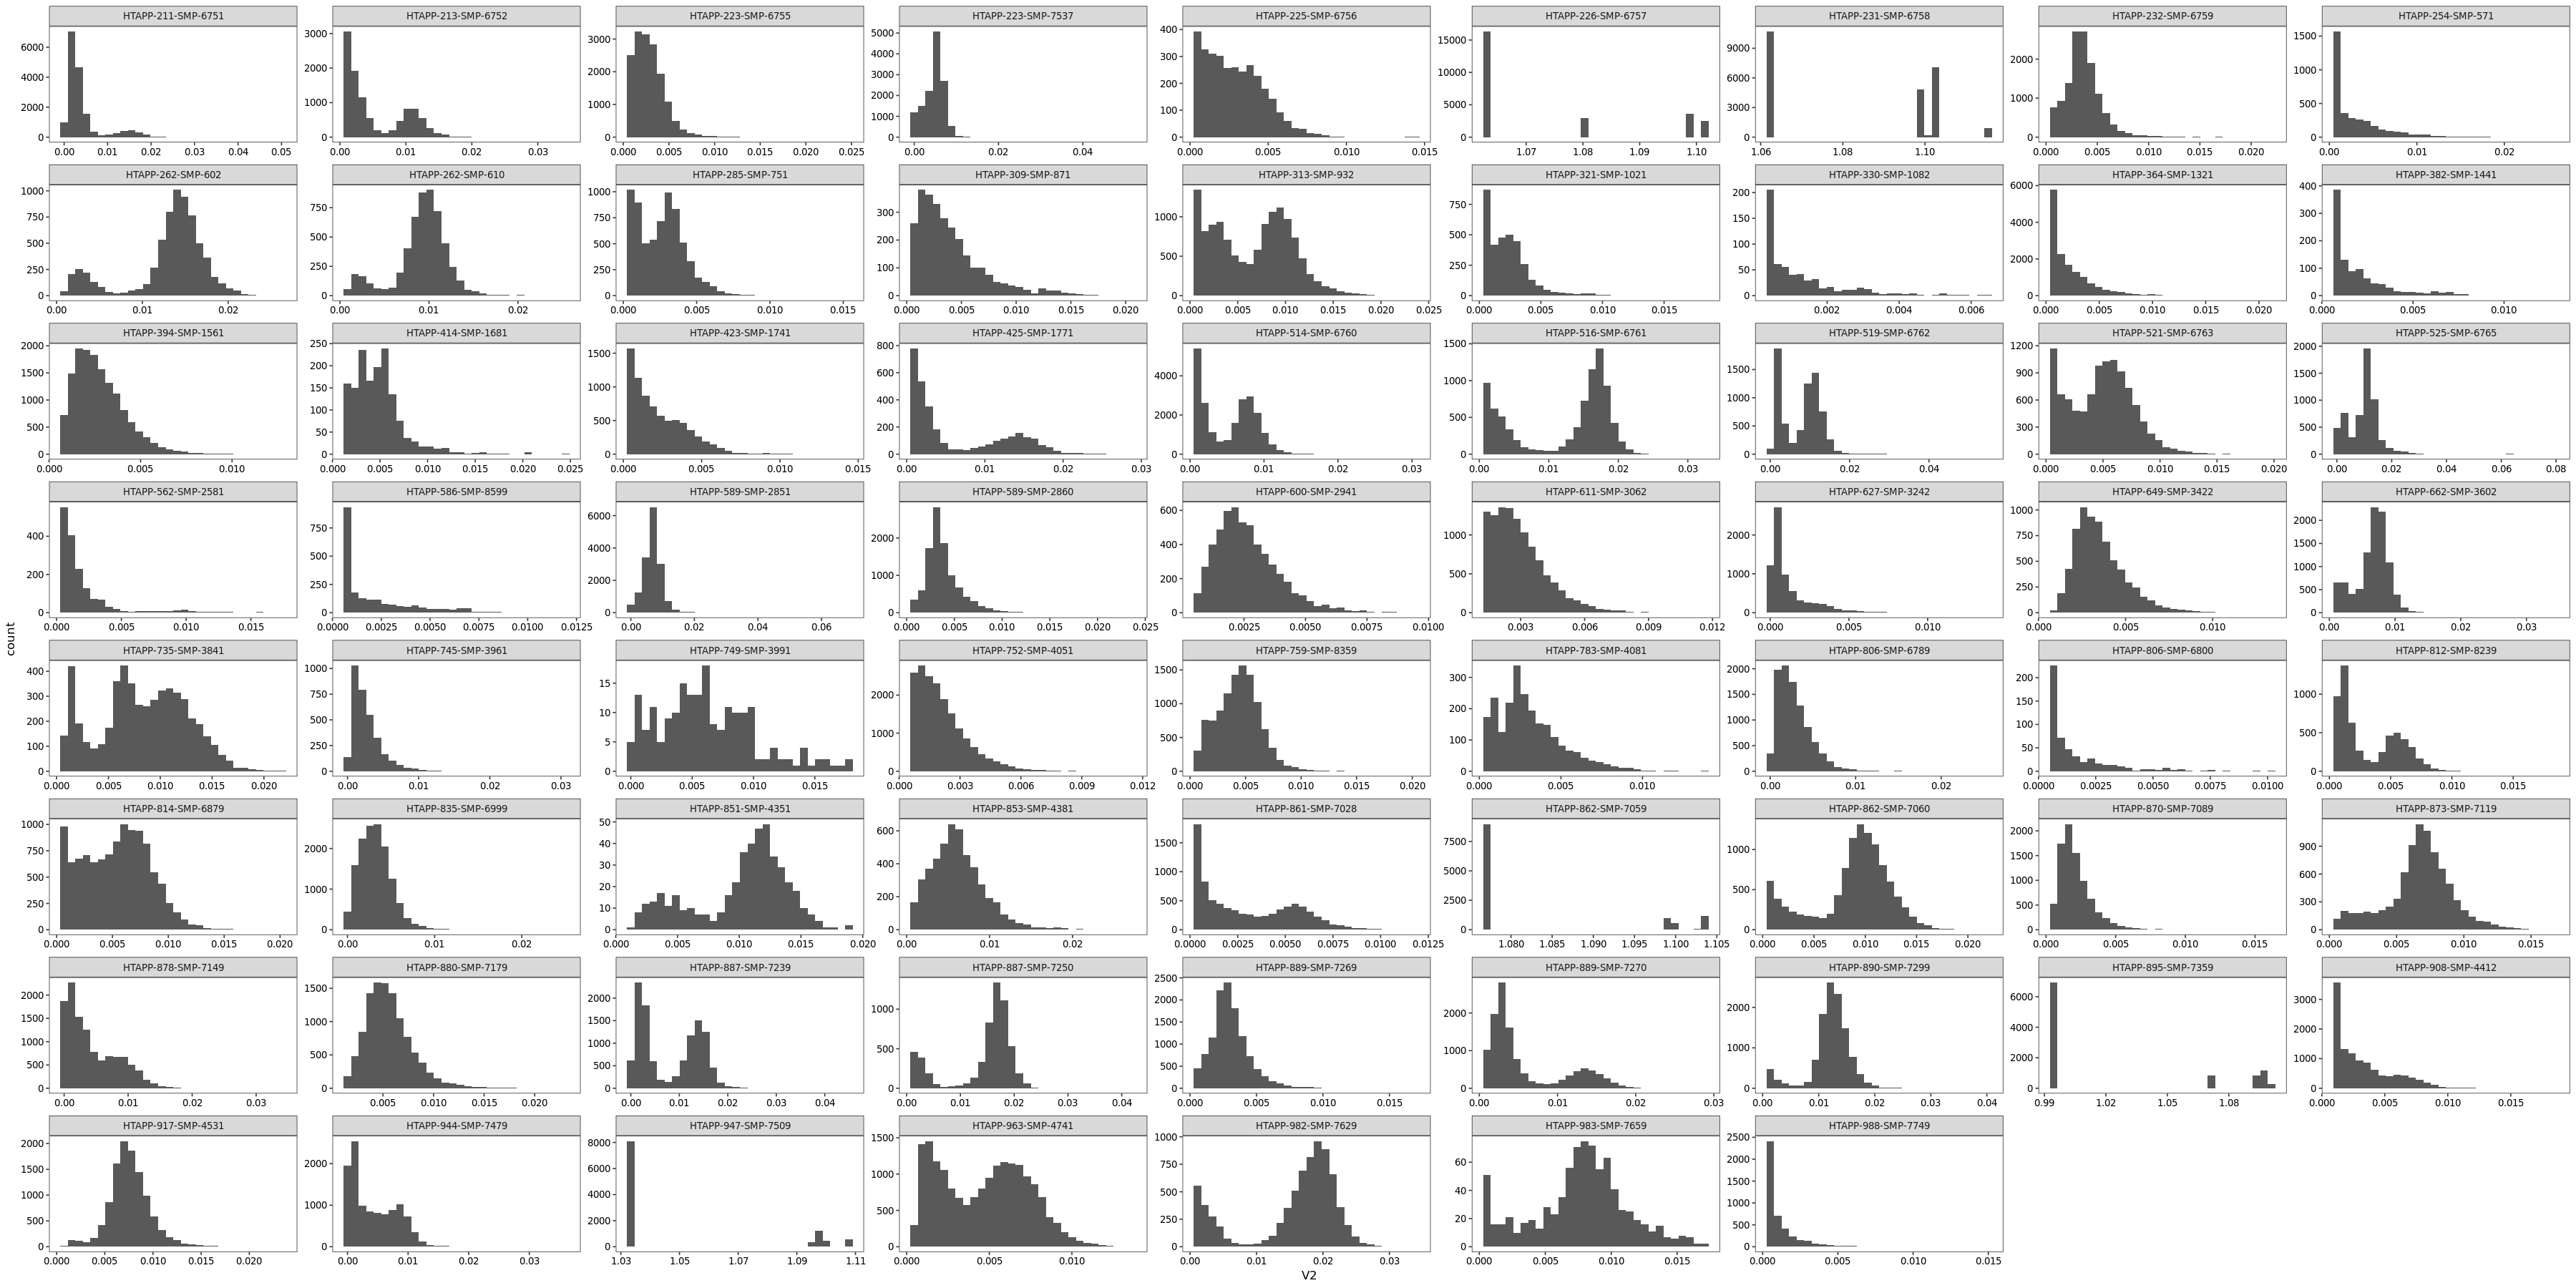

In [134]:
options(repr.plot.width = 30, repr.plot.height =15)
ggplot(all_scores,aes(x=V2))+geom_histogram()+facet_wrap(~sampleID,scale="free")

In [135]:
all_cors=data.table()
for (sample in head(samples,-1)){
    cors=fread(paste0(out,"/cnv_cors_",sample,".tsv"))   
    all_cors=rbindlist(list(all_cors,cors))
}

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 13981 rows containing non-finite values (stat_bin)."

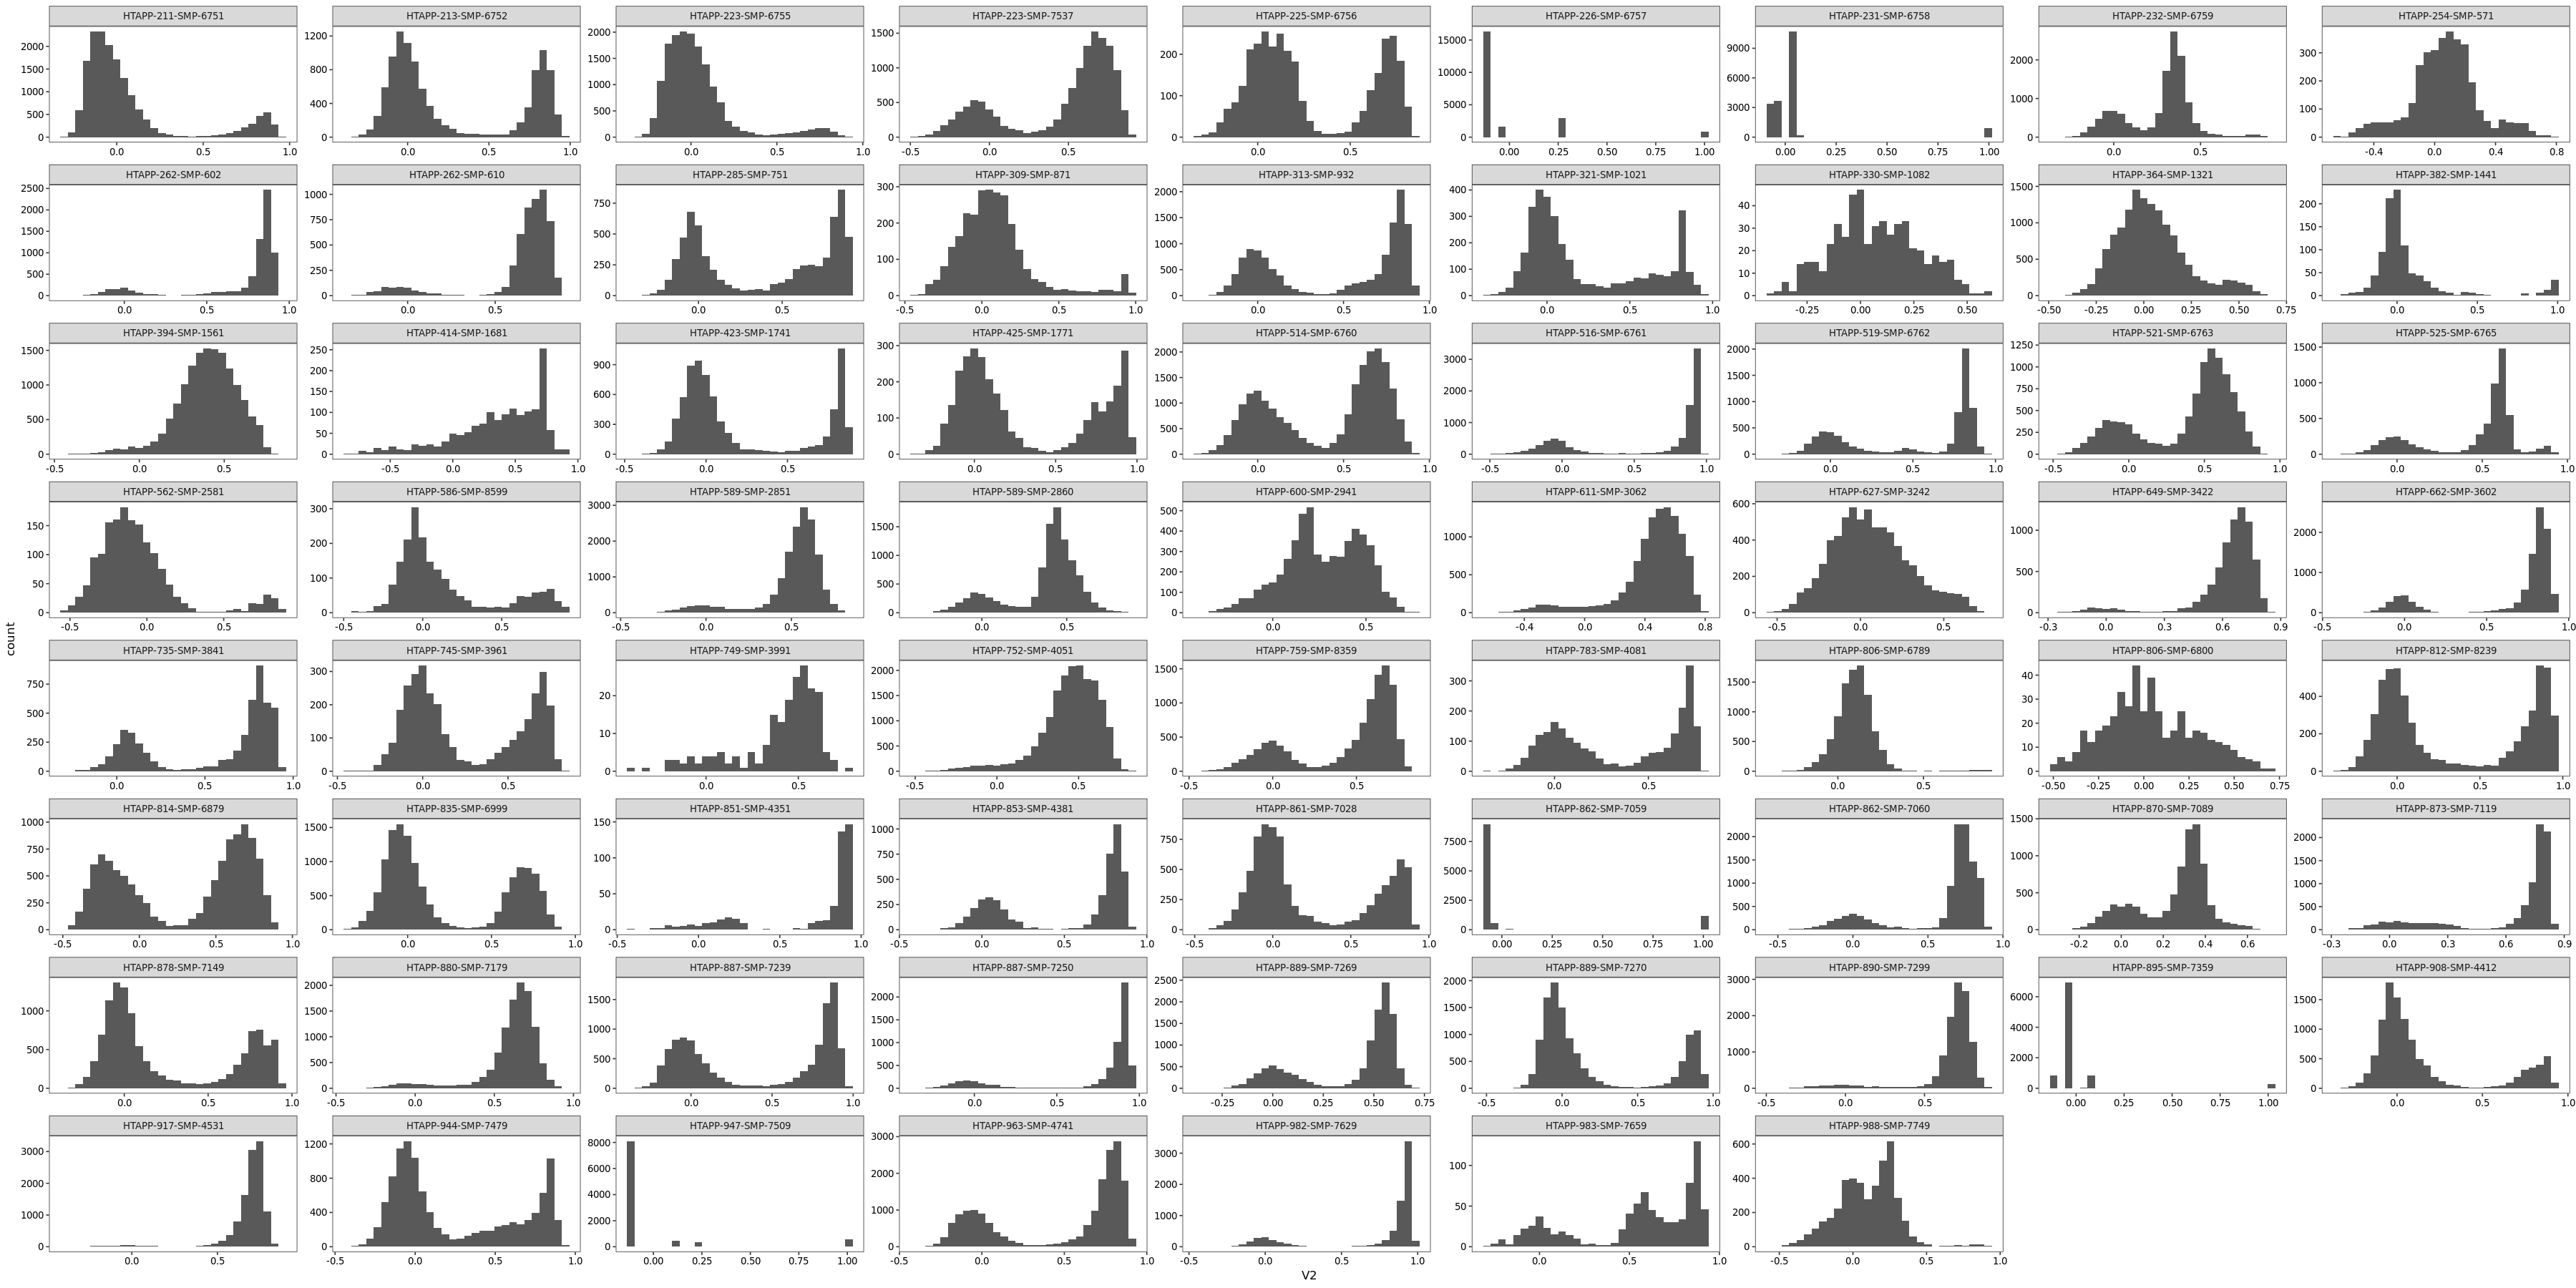

In [136]:
options(repr.plot.width = 30, repr.plot.height =15)
ggplot(all_cors,aes(x=V2))+geom_histogram()+facet_wrap(~sampleID,scale="free")

#### Follow-up on problematic samples

In [137]:
#sample="HTAPP-752-SMP-4051" #(only one peak)
sample="HTAPP-890-SMP-7299"
obj=readRDS(paste0(infercnvDir,sample,"/out/run.final.infercnv_obj"))
hi_means=apply(obj@expr.data,2,function(x){mean(abs(log(runner(x,k=50,f=function(x){x[which.min(abs(1-x))]}))))})

In [138]:
max_mal=tail( order(hi_means), 80 )
mal_profile=apply(obj@expr.data[,max_mal],1,mean)

#mal_profile=apply(obj@expr.data[,obj@observation_grouped_cell_indices$Epithelial],1,median)
cors=apply(obj@expr.data,2,function(x){cor(x,mal_profile)})

Warning message in cor(x, mal_profile):
"the standard deviation is zero"

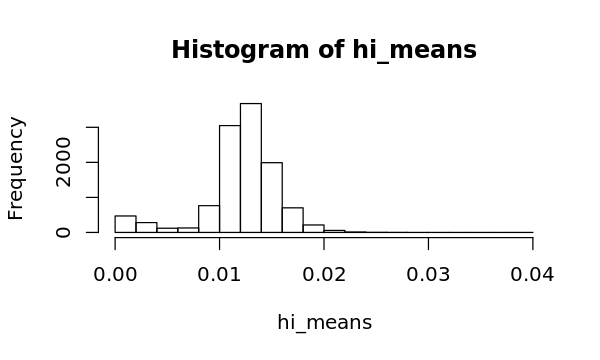

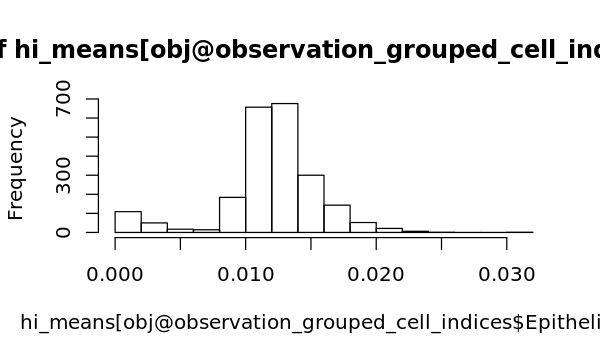

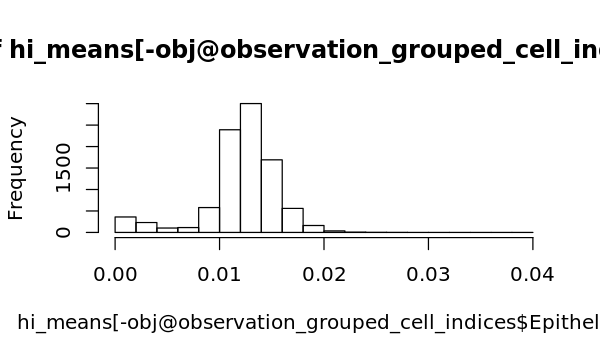

In [139]:
options(repr.plot.width = 5, repr.plot.height =3)
hist(hi_means)
hist(hi_means[obj@observation_grouped_cell_indices$Epithelial])
hist(hi_means[-obj@observation_grouped_cell_indices$Epithelial])

### Take clusters into account

In [74]:
library(ape)

In [148]:
mal_ct=c("Epithelial","Neurons","Chondrocyte","iPS","Mesangial cells")

In [ ]:
#turn off wanrings because of "the standard deviation is zero"Warning message in cor(x, ref)" warnings
oldw <- getOption("warn")
options(warn = -1)

for (sample in samples){
    message(sample)
    max_profile_score=0
    #if(file.exists(paste0(out,"/cnv_scores_clusters_",sample,".tsv"))){print("Already done.");next}
    #get data
    obj=readRDS(paste0(infercnvDir,sample,"/out/run.final.infercnv_obj"))
    tree= read.tree(paste0(infercnvDir,sample,"/out/infercnv.observations_dendrogram.txt"))
   
    #assign clusters
    clusters=c()
    if(is(tree)=="phylo"){ max_iter=1}else{max_iter=length(tree)}
    
    for (i in 1:max_iter){
        if(max_iter==1){hc=as.hclust(tree)}else{hc=as.hclust(tree[[i]])}
        #k=min(floor(sqrt(length(hc$labels)/1000))+1,3)
        heights=sort(hc$height,decreasing=TRUE)
        rel_heights=heights/max(heights)
        diff_heights=abs(rel_heights-c(0,head(rel_heights,-1)))
        k=max(which(rel_heights>=0.5&diff_heights>0.2))+1

        sub_clusters=cutree(hc,k=k)
        while((min(table(sub_clusters)))<50&k>1){
            k=k-1
            sub_clusters=cutree(hc,k=k)
        }
        
        ct=names(obj@observation_grouped_cell_indices)[i]
        sub_clusters[]=paste0(ct,"_",sub_clusters)
        clusters=c(clusters,sub_clusters)
    }
    

    #find strongest profile
    for (cl in unique(clusters)){
        #observations
        sub=obj@expr.data[,names(clusters[clusters==cl]),drop=FALSE]
        profile=apply(sub,1,mean)
        profile_score=mean(abs(log(runner(profile,k=50,f=function(x){x[which.min(abs(1-x))]}))))
        
        #store stongest profile (likely malignant)
        n_clusters=table(clusters)
        n_clusters_cl=n_clusters[grepl(sub("_[1-9*$]","",cl),names(n_clusters))]
        if (profile_score>max_profile_score&(ncol(sub)>200|max(n_clusters)<=200|(grepl(paste0(mal_ct,collapse = "|"),cl)&(n_clusters_cl/sum(n_clusters_cl))[cl]>0.1))){
            max_profile_score=profile_score
            max_profile=profile
            max_cluster=cl
            }
    }
    
    #calculate scores and correlations for clusters
    all_res=data.table()
    for (cl in unique(clusters)){
    
        #observations
        sub=obj@expr.data[,names(clusters[clusters==cl]),drop=FALSE]
        profile=apply(sub,1,mean)
        profile_score=mean(abs(log(runner(profile,k=50,f=function(x){x[which.min(abs(1-x))]}))))
        cors=apply(sub,2,function(x){cor(x,profile)})
        cors_max=apply(sub,2,function(x){cor(x,max_profile)})
        
        all_res=rbindlist(list(all_res,data.table(cellid=names(cors),sample=sample,cluster=cl,cors=cors,cors_max=cors_max,score=profile_score)))
        
        }
    
    #calculate scores and correlations for reference
    ref_idx=obj@reference_grouped_cell_indices
    all_ref_scores=c()
    for (cluster in names(ref_idx)){
        ref_dat=obj@expr.data[,unlist(ref_idx[[cluster]])]
        ref=apply(ref_dat,1,mean)
        ref_score=mean(abs(log(runner(ref,k=50,f=function(x){x[which.min(abs(1-x))]}))))
        ref_cors=apply(ref_dat,2,function(x){cor(x,ref)})
        ref_cors_max=apply(ref_dat,2,function(x){cor(x,max_profile)})
        all_res=rbindlist(list(all_res,data.table(cellid=names(ref_cors),sample=sample,cluster=cluster,cors=ref_cors,cors_max=ref_cors_max,score=ref_score)))
        all_ref_scores=c(all_ref_scores,ref_score)
    }
    all_res[,ref_score:=mean(all_ref_scores),]
    all_res[,score_norm:=score/ref_score,]
    all_res[,score_norm_norm:=score_norm/unique(score_norm[cluster==max_cluster]),]
    all_res[,max_cluster:=max_cluster,]
    write.table(all_res,paste0(out,"/cnv_scores_clusters_",sample,".tsv"),sep="\t",row.names=FALSE,quote = FALSE)
}
options(warn = oldw)

In [143]:
#collect all the data
res=data.table()
for (sample in samples){
    res=rbindlist(list(res,fread(paste0(out,"/cnv_scores_clusters_",sample,".tsv"))))
}

In [144]:
res=merge(res,unique(sample_sheet[condition%in%c("TST","fresh"),c("sampleid","condition","mode")]),by.x="sample",by.y="sampleid",all.x = TRUE)

In [145]:
res[,score_norm_norm2:=score_norm/max(score_norm),by=sample]

In [146]:
res[,score_norm_norm:=min(c(1,score_norm_norm)),by=1:nrow(res)]

In [147]:
res[,cell_type:=sub("_[1-9]*$","",cluster),]

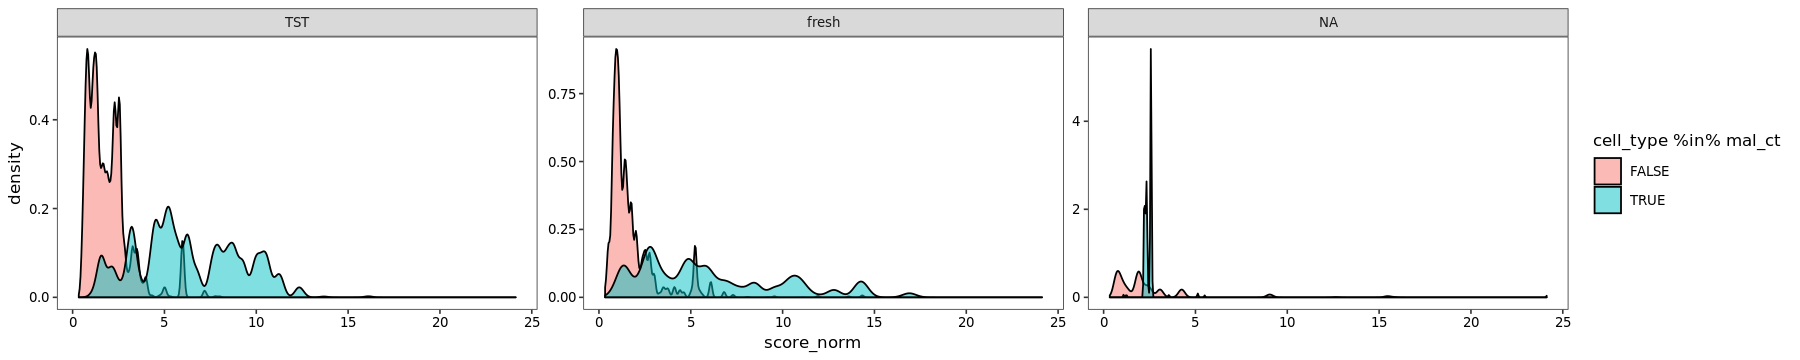

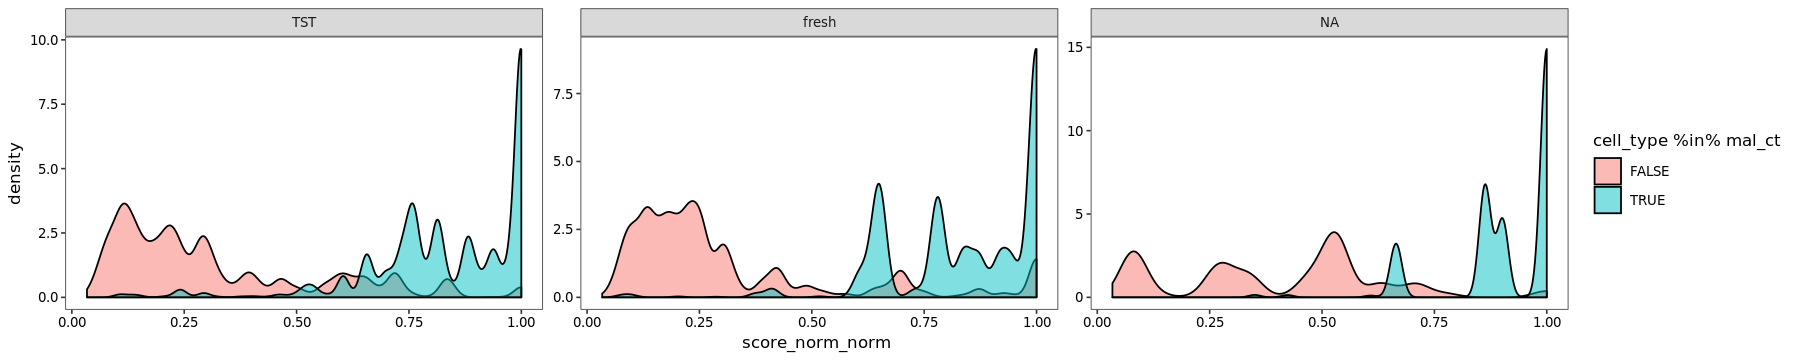

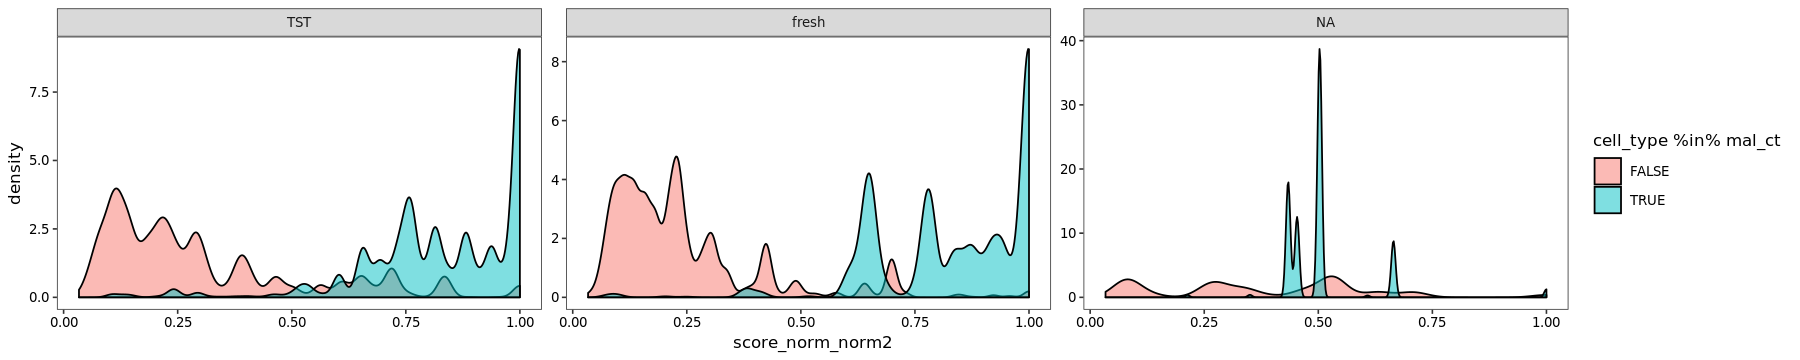

In [149]:
options(repr.plot.width = 15, repr.plot.height =3)
ggplot(res,aes(x=score_norm,fill=cell_type%in%mal_ct))+geom_density(alpha = 0.5)+facet_wrap(~condition,scales = "free_y")
ggplot(res,aes(x=score_norm_norm,fill=cell_type%in%mal_ct))+geom_density(alpha = 0.5)+facet_wrap(~condition,scales = "free_y")
ggplot(res,aes(x=score_norm_norm2,fill=cell_type%in%mal_ct))+geom_density(alpha = 0.5)+facet_wrap(~condition,scales = "free_y")

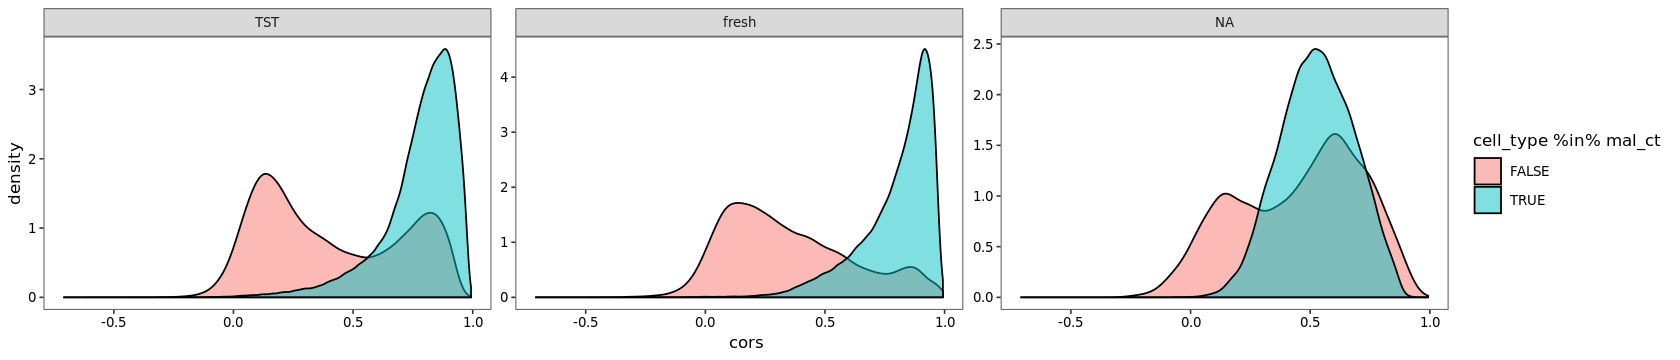

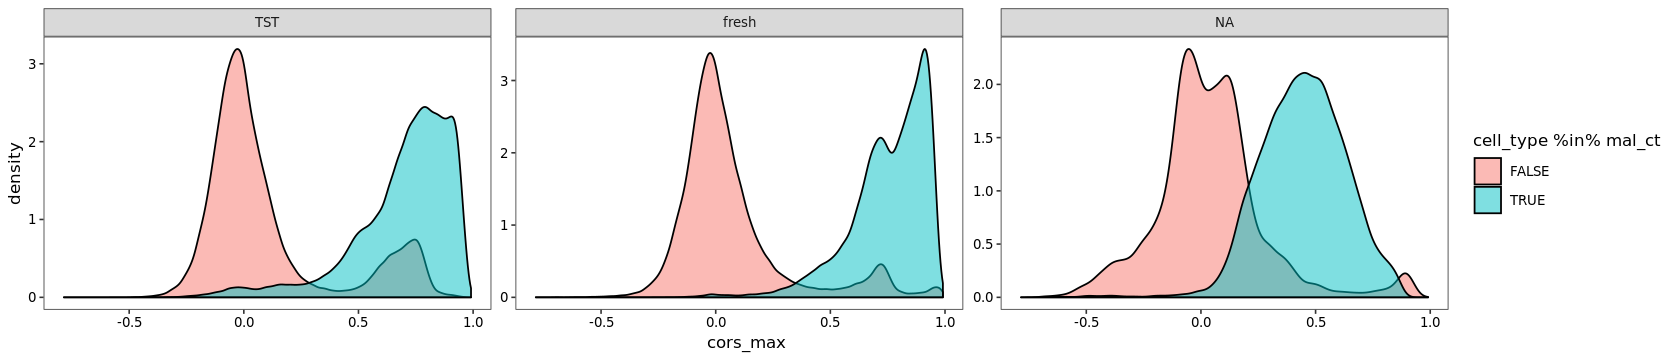

In [150]:
options(repr.plot.width = 14, repr.plot.height =3)
ggplot(res,aes(x=cors,fill=cell_type%in%mal_ct))+geom_density(alpha = 0.5)+facet_wrap(~condition,scales = "free_y")
ggplot(res,aes(x=cors_max,fill=cell_type%in%mal_ct))+geom_density(alpha = 0.5)+facet_wrap(~condition,scales = "free_y")

In [151]:
#thresholds
th_score=0.5
th_cor=0.1
th_cor_max_1=0.1
th_cor_max_2=0.4

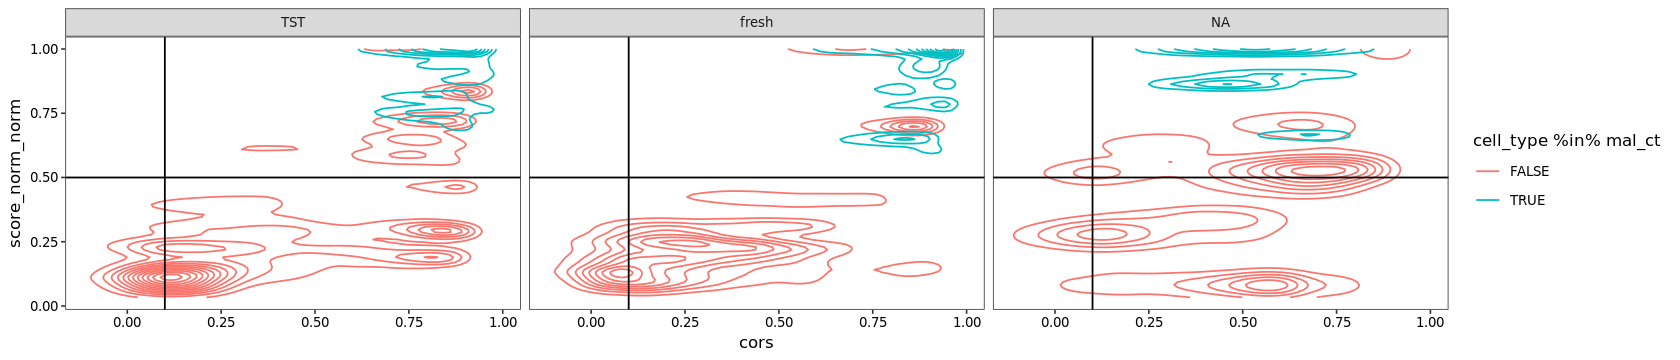

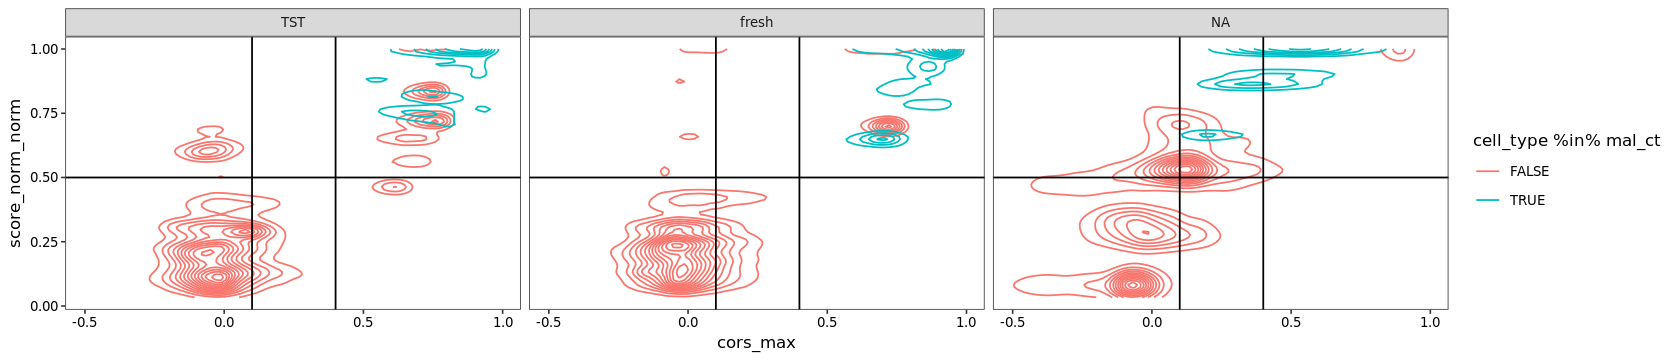

In [152]:
options(repr.plot.width = 14, repr.plot.height =3)
ggplot(res,aes(x=cors,y=score_norm_norm,col=cell_type%in%mal_ct))+geom_density2d()+geom_hline(yintercept = th_score)+geom_vline(xintercept = th_cor)+facet_wrap(~condition)
ggplot(res,aes(x=cors_max,y=score_norm_norm,col=cell_type%in%mal_ct))+geom_density2d()+geom_hline(yintercept = 0.5)+geom_vline(xintercept = c(th_cor_max_1,th_cor_max_2))+facet_wrap(~condition)

In [153]:
# call without "prioritizing" malignant cell types
res[,pass:=ifelse(((score_norm_norm>=th_score&cors>th_cor&
                                        (cors_max>=th_cor_max_1))|(cors_max>=th_cor_max_2)),TRUE,FALSE),]

# call with "prioritizing" malignant cell types
res[,pass_mal:=ifelse(((score_norm_norm>=th_score&cors>th_cor&
                                        (cors_max>=th_cor_max_1|cell_type%in%mal_ct))|(cors_max>=th_cor_max_2))&
                                      grepl(paste0(mal_ct,collapse = "|"),max_cluster),TRUE,FALSE),]

res[is.na(pass),pass:=FALSE,]
res[is.na(pass_mal),pass_mal:=FALSE,]

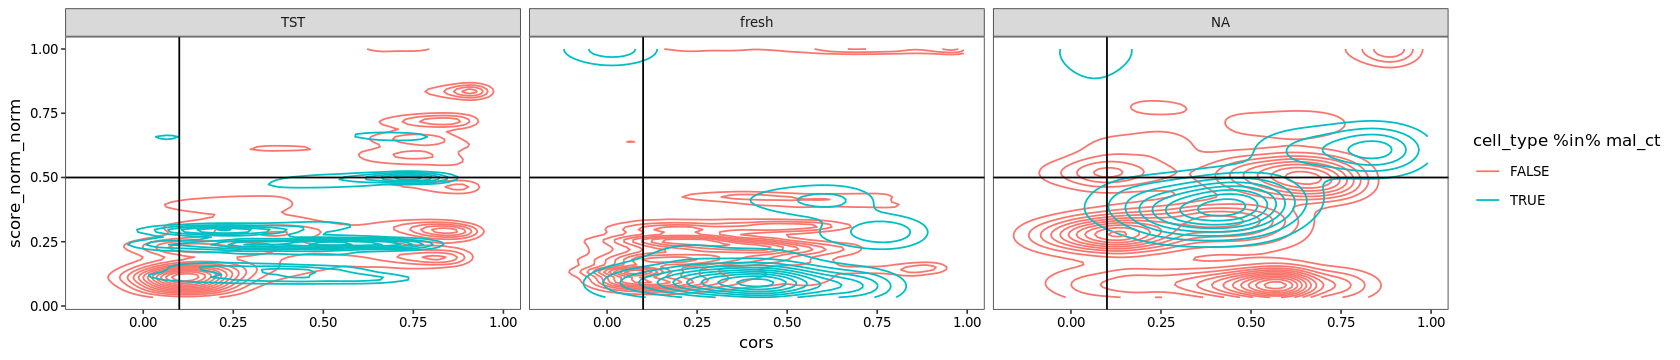

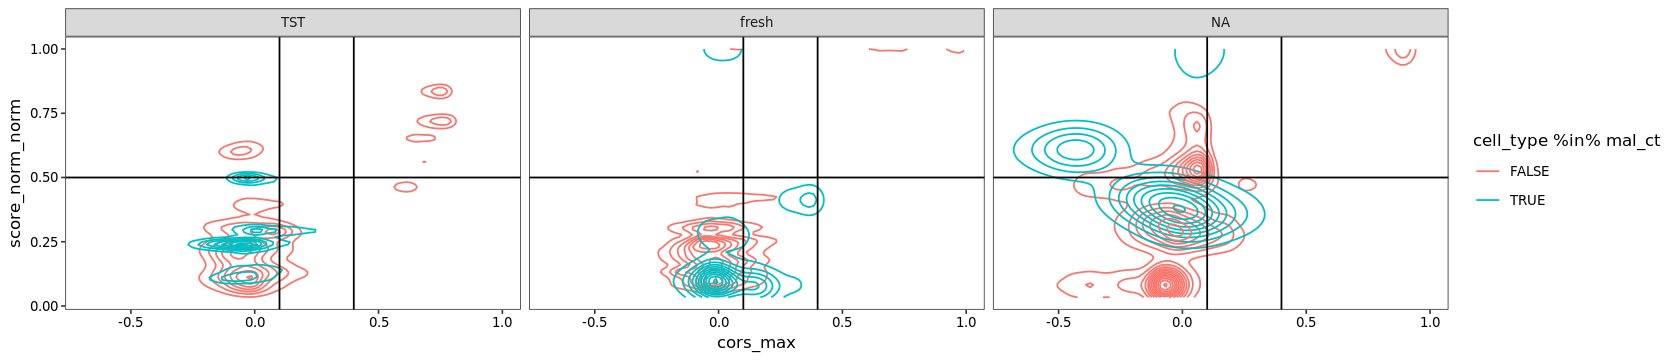

In [154]:
options(repr.plot.width = 14, repr.plot.height =3)
ggplot(res[pass_mal==FALSE],aes(x=cors,y=score_norm_norm,col=cell_type%in%mal_ct))+geom_density2d()+geom_hline(yintercept = th_score)+geom_vline(xintercept = th_cor)+facet_wrap(~condition)
ggplot(res[pass_mal==FALSE],aes(x=cors_max,y=score_norm_norm,col=cell_type%in%mal_ct))+geom_density2d()+geom_hline(yintercept = 0.5)+geom_vline(xintercept = c(th_cor_max_1,th_cor_max_2))+facet_wrap(~condition)

In [158]:
#check potential false positives and true negatives
res[,sum(!cell_type%in%mal_ct),by=c("condition","pass_mal","pass")][order(condition,pass_mal,pass)]

condition,pass_mal,pass,V1
<chr>,<lgl>,<lgl>,<int>
TST,FALSE,FALSE,173693
TST,FALSE,TRUE,30144
TST,TRUE,FALSE,0
TST,TRUE,TRUE,7638
fresh,FALSE,FALSE,74275
fresh,FALSE,TRUE,4460
fresh,TRUE,FALSE,0
fresh,TRUE,TRUE,6074
NA,FALSE,FALSE,5628


In [159]:
#check potential true positives and false negatives
res[,sum(cell_type%in%mal_ct),by=c("condition","pass_mal","pass")][order(condition,pass_mal,pass)]

condition,pass_mal,pass,V1
<chr>,<lgl>,<lgl>,<int>
TST,FALSE,FALSE,7307
TST,FALSE,TRUE,204
TST,TRUE,FALSE,1021
TST,TRUE,TRUE,225285
fresh,FALSE,FALSE,755
fresh,FALSE,TRUE,0
fresh,TRUE,FALSE,43
fresh,TRUE,TRUE,81775
NA,FALSE,FALSE,225


In [160]:
head(res)

sample,cellid,cluster,cors,cors_max,score,ref_score,score_norm,score_norm_norm,max_cluster,condition,mode,score_norm_norm2,cell_type,pass,pass_mal
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<lgl>
HTAPP-211-SMP-6751,HTAPP-211-SMP-6751-TST-channel1_GTACAACAGAAGCGCT-1,Epithelial_1,0.3763075,0.1958417,0.002344976,0.001350417,1.736483,0.1413485,Epithelial_3,TST,V3,0.1406958,Epithelial,FALSE,FALSE
HTAPP-211-SMP-6751,HTAPP-211-SMP-6751-TST-channel1_GAAGGGTCAGCTGTAT-1,Epithelial_1,0.3510974,0.3357747,0.002344976,0.001350417,1.736483,0.1413485,Epithelial_3,TST,V3,0.1406958,Epithelial,FALSE,FALSE
HTAPP-211-SMP-6751,HTAPP-211-SMP-6751-TST-channel1_TGTCAGAGTCTCGGAC-1,Epithelial_1,0.3252652,0.2909931,0.002344976,0.001350417,1.736483,0.1413485,Epithelial_3,TST,V3,0.1406958,Epithelial,FALSE,FALSE
HTAPP-211-SMP-6751,HTAPP-211-SMP-6751-TST-channel1_GCGAGAAAGCTCTGTA-1,Epithelial_1,0.2455842,0.1407044,0.002344976,0.001350417,1.736483,0.1413485,Epithelial_3,TST,V3,0.1406958,Epithelial,FALSE,FALSE
HTAPP-211-SMP-6751,HTAPP-211-SMP-6751-TST-channel1_TAGGAGGTCGTCAGAT-1,Epithelial_1,0.3016682,0.3092810,0.002344976,0.001350417,1.736483,0.1413485,Epithelial_3,TST,V3,0.1406958,Epithelial,FALSE,FALSE
HTAPP-211-SMP-6751,HTAPP-211-SMP-6751-TST-channel1_CCTCATGAGCTGACCC-1,Epithelial_1,0.3931749,0.2579192,0.002344976,0.001350417,1.736483,0.1413485,Epithelial_3,TST,V3,0.1406958,Epithelial,FALSE,FALSE


In [165]:
res_out=copy(res)
setnames(res_out,colnames(res),paste0("cnv_",colnames(res)))

In [166]:
write.table(res_out,file = paste0(out,"/cnv_scores_clusters.tsv"),sep="\t",row.names = FALSE,quote=FALSE)

#### Investigate starnge cases

In [164]:
#check out single samples
check_sample="HTAPP-586-SMP-8599"
res[sample==check_sample,.(N=.N,cors=median(cors,na.rm = TRUE),cors_max=median(cors_max,na.rm = TRUE),pass_mal=sum(pass_mal),pass=sum(pass)),by=c("cluster","score_norm_norm","score")]

cluster,score_norm_norm,score,N,cors,cors_max,pass_mal,pass
<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>
Chondrocyte_1,1.00000000,0.0060983404,294,0.7733044,0.773304355,294,294
Chondrocyte_2,0.63089379,0.0038474051,104,0.5693816,0.545309151,99,97
CD8+ T-cells_1,0.08518941,0.0005195140,693,0.2688259,-0.033323665,6,6
B_1,0.10518732,0.0006414681,57,0.7905541,-0.086572372,0,0
Melanocytes_1,0.43817089,0.0026721153,68,0.3195827,0.266155321,26,26
Adipocytes_1,0.39265770,0.0023945603,126,0.2846554,0.061798933,1,1
Endothelial,0.14556971,0.0008877337,79,0.2208387,-0.009690289,0,0
Fibroblast,0.15714204,0.0009583056,296,0.1110932,0.037142014,10,10
Macrophage,0.18505029,0.0011284997,375,0.1648859,-0.059049365,1,1
